### VARMA(p,q) : Vector Auto Regression Moving Average models!

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("C:\\Users\\shaleens\\Desktop\\Projects\\TimeSeriesUdacity\\TS Udemy Vids\\Time Series 2\\VAR model dataset\\M2.csv", index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv("C:\\Users\\shaleens\\Desktop\\Projects\\TimeSeriesUdacity\\TS Udemy Vids\\Time Series 2\\VAR model dataset\\PCE.csv", index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [2]:
df.rename(columns={'M2NS':'Money'}, inplace=True)

In [3]:
sp.rename(columns={'PCE':'Spend'}, inplace=True)

In [4]:
# Lets go ahead and combines the 2 dataframes:

df = pd.merge(df, sp, how='inner', on='DATE')

In [5]:
df.head()

,Money,Spend
DATE,,
1995-01-01,3495.3,4851.2
1995-02-01,3474.9,4850.8
1995-03-01,3491.7,4885.4
1995-04-01,3522.4,4890.2
1995-05-01,3506.7,4933.1


In [6]:
df.shape

(300, 2)

In [7]:
df.dropna().shape 
# This confirms that there is no null value to be treated

(300, 2)

In [8]:
df = df.iloc[:252]

In [9]:
df.tail()

,Money,Spend
DATE,,
2015-08-01,12058.7,12387.0
2015-09-01,12126.3,12384.5
2015-10-01,12159.8,12387.3
2015-11-01,12286.2,12422.8
2015-12-01,12416.1,12453.8


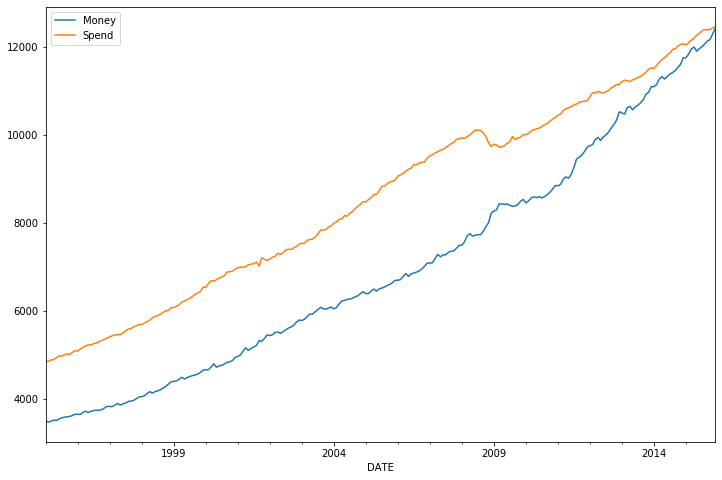

In [10]:
df.plot(figsize=(12,8))

##### Now, we will perform auto_arima prediction to identify optimal p and q orders:

In [11]:
auto_arima(df['Money'], maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(2, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [12]:
auto_arima(df['Spend'], maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(1, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

##### Since, auto_arima already informed us abt stationarity of series, we dont need to run Dickey-fuller!
##### Rather directly diff the series to majke it Stationary!

In [16]:
# Using inbuilt function of pandas dataframe for differencing the series:

df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spend
DATE,,
1995-03-01,37.2,35.0
1995-04-01,13.9,-29.8
1995-05-01,-46.4,38.1
1995-06-01,54.5,1.5
1995-07-01,-14.6,-51.7


##### Notice that we have performed doubke differencing as suggested by auto_arima and we can see we have lost 2 rows of data i.e for Jan month and Feb month!

##### Now the columns in dataframe are completely stationary!

In [17]:
df_transformed.shape

(250, 2)

##### Train-test split:

In [18]:
n_obs = 12

train = df_transformed[:-n_obs]
test = df_transformed[-n_obs:]

In [19]:
train.shape, test.shape

((238, 2), (12, 2))

##### Fit the VARMA model:

In [26]:
model = VARMAX(train, order=(1,2), trend='c')

In [27]:
results = model.fit(maxiter=1000, disp=False) #disp is display

In [28]:
results.summary()

Dep. Variable:,"['Money', 'Spend']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2389.242
,+ intercept,AIC,4812.484
Date:,"Mon, 02 Mar 2020",BIC,4871.512
Time:,23:09:55,HQIC,4836.273
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"320.40, 32.04",Jarque-Bera (JB):,"4.15, 72.57"
Prob(Q):,"0.00, 0.81",Prob(JB):,"0.13, 0.00"
Heteroskedasticity (H):,"3.76, 2.46",Skew:,"0.10, -0.15"


In [30]:
df_forecast = results.forecast(12) # steps is number of periods to predict.

In [31]:
df_forecast

,Money,Spend
2015-01-01,-80.624140,16.801971
2015-02-01,-5.900099,16.418502
2015-03-01,-10.320018,-18.082846
2015-04-01,19.136004,19.155494
2015-05-01,-23.090683,-19.468230
2015-06-01,25.641614,19.850498
2015-07-01,-26.396176,-19.810603
2015-08-01,27.312529,20.012759
2015-09-01,-27.232175,-19.880872
2015-10-01,27.722073,20.036047


##### Inverting the Transformation:

In [33]:
df_forecast.columns

Index(['Money', 'Spend'], dtype='object')

In [34]:
df_forecast['Money_1d'] = (df['Money'].iloc[-n_obs-1] - df['Money'].iloc[-n_obs-2]) + df_forecast['Money'].cumsum()

df_forecast['MoneyForecast'] = df['Money'].iloc[-n_obs-1] + df_forecast['Money_1d'].cumsum()

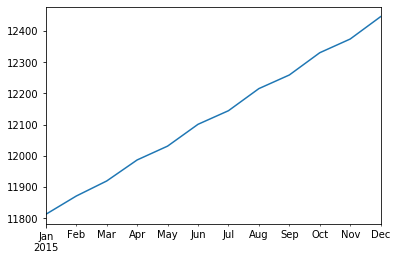

In [35]:
df_forecast['MoneyForecast'].plot()

In [36]:
df_forecast['Spend_1d'] = (df['Spend'].iloc[-n_obs-1] - df['Spend'].iloc[-n_obs-2]) + df_forecast['Spend'].cumsum()

df_forecast['SpendForecast'] = df['Spend'].iloc[-n_obs-1] + df_forecast['Spend_1d'].cumsum()

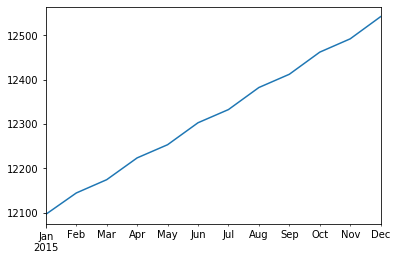

In [38]:
df_forecast['SpendForecast'].plot()

In [39]:
df_forecast.head()

,Money,Spend,Money_1d,MoneyForecast,Spend_1d,SpendForecast
2015-01-01,-80.624140,16.801971,64.475860,11812.375860,31.601971,12096.601971
2015-02-01,-5.900099,16.418502,58.575761,11870.951621,48.020473,12144.622444
2015-03-01,-10.320018,-18.082846,48.255743,11919.207363,29.937628,12174.560072
2015-04-01,19.136004,19.155494,67.391747,11986.599110,49.093121,12223.653193
2015-05-01,-23.090683,-19.468230,44.301063,12030.900174,29.624892,12253.278085


In [41]:
pd.concat([df.iloc[-12:], df_forecast[['MoneyForecast','SpendForecast']]], axis=1)

,Money,Spend,MoneyForecast,SpendForecast
2015-01-01,11746.9,12039.9,11812.375860,12096.601971
2015-02-01,11835.1,12089.1,11870.951621,12144.622444
2015-03-01,11944.9,12145.7,11919.207363,12174.560072
2015-04-01,11992.7,12187.4,11986.599110,12223.653193
2015-05-01,11896.1,12261.1,12030.900174,12253.278085
2015-06-01,11950.7,12295.6,12100.842851,12302.753475
2015-07-01,12001.3,12357.1,12144.389353,12332.418262
2015-08-01,12058.7,12387.0,12215.248384,12382.095807
2015-09-01,12126.3,12384.5,12258.875239,12411.892481
2015-10-01,12159.8,12387.3,12330.224168,12461.725202


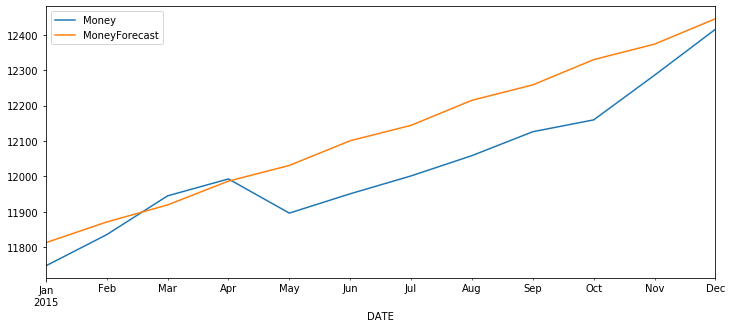

In [43]:
df['Money'][-n_obs:].plot(figsize=(12,5), legend=True)
df_forecast['MoneyForecast'].plot(legend=True)

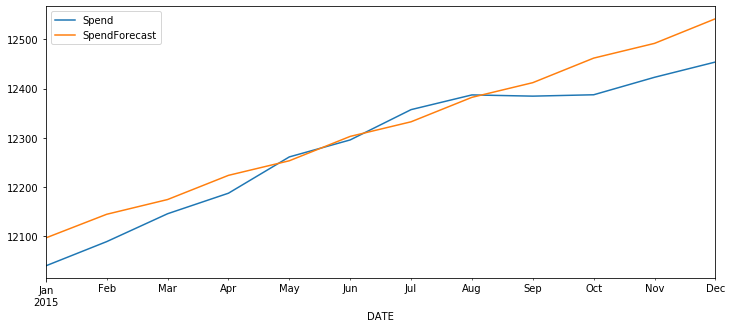

In [45]:
df['Spend'][-n_obs:].plot(figsize=(12,5),legend=True)
df_forecast['SpendForecast'].plot(legend=True)

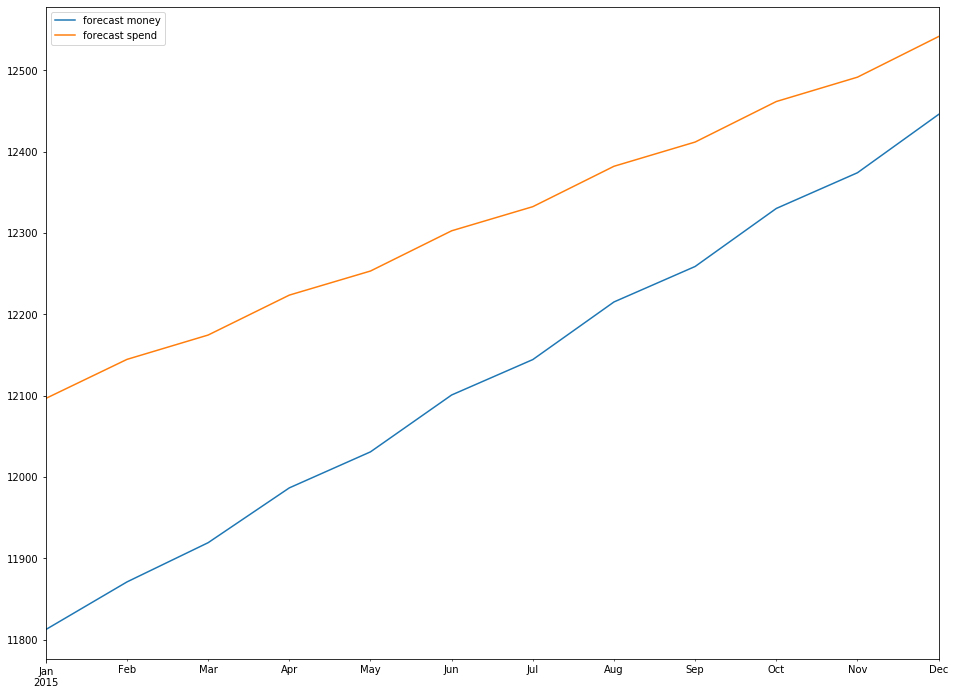

In [46]:
df_forecast['MoneyForecast'].rename('forecast money').plot(legend=True, figsize=(16,12))
df_forecast['SpendForecast'].rename('forecast spend').plot(legend=True)

In [47]:
rmse(df['Money'][-n_obs:], df_forecast['MoneyForecast'])

110.75799042535651

In [48]:
df['Money'][-n_obs:].mean()

12034.566666666668

In [49]:
rmse(df['Spend'][-n_obs:], df_forecast['SpendForecast'])

48.254940064250626

##### We can see we managed to reduce the error in the Money column upto great extent! However, there is a very very slight increase in error of Spend as compared to VAR model!

Still, we can say VARMA is performing pretty decent on our dataset

---------

##### Lets try and compare these results to individual ARMA(1,2) model
##### i.e. we are assuming no relationship between the two series!

In [51]:
from statsmodels.tsa.arima_model import ARMA, ARMAResults

##### Money:

In [52]:
model = ARMA(train['Money'], order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1234.869
Method:                       css-mle   S.D. of innovations             42.880
Date:                Mon, 02 Mar 2020   AIC                           2479.738
Time:                        23:36:50   BIC                           2497.099
Sample:                    03-01-1995   HQIC                          2486.735
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1902      0.045      4.266      0.000       0.103       0.278
ar.L1.Money    -0.4459      0.129     -3.465      0.001      -0.698      -0.194
ma.L1.Money    -0.3950      0.105     -3.754      0.000      -0.601      -0.189
ma.L2.Money    -0.6050      0.105     -5.775      0.000      -0.810      -0.400
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.2426           +0.0000j            2.2426            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6528           +0.0000j            1.6528            0.5000
-----------------------------------------------------------------------------
"""

In [53]:
start = len(train)
end = len(train) + len(test) - 1

z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [54]:
z1

,Money
2015-01-01,-75.021344
2015-02-01,-18.790995
2015-03-01,8.653972
2015-04-01,-3.583805
2015-05-01,1.873049
2015-06-01,-0.560175
2015-07-01,0.524805
2015-08-01,0.041010
2015-09-01,0.256736
2015-10-01,0.160543


In [55]:
z1['Money1d'] = (df['Money'].iloc[-n_obs-1] - df['Money'].iloc[-n_obs-2]) + z1['Money'].cumsum()

z1['MoneyForecast'] = df['Money'].iloc[-n_obs-1] + z1['Money1d'].cumsum()

In [56]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-75.021344,70.078656,11817.978656
2015-02-01,-18.790995,51.287662,11869.266318
2015-03-01,8.653972,59.941633,11929.207951
2015-04-01,-3.583805,56.357829,11985.565780
2015-05-01,1.873049,58.230878,12043.796658
2015-06-01,-0.560175,57.670703,12101.467361
2015-07-01,0.524805,58.195508,12159.662869
2015-08-01,0.041010,58.236518,12217.899387
2015-09-01,0.256736,58.493254,12276.392641
2015-10-01,0.160543,58.653797,12335.046438


In [57]:
rmse(df['Money'][-n_obs:], z1['MoneyForecast'])

118.20947449892496

##### Now, for Spend column:

In [59]:
model = ARMA(train['Spend'], order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Spend   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.737
Method:                       css-mle   S.D. of innovations             34.709
Date:                Mon, 02 Mar 2020   AIC                           2375.474
Time:                        23:43:28   BIC                           2392.835
Sample:                    03-01-1995   HQIC                          2382.471
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0881      0.245      0.359      0.720      -0.393       0.569
ar.L1.Spend    -0.3246      0.501     -0.648      0.517      -1.307       0.657
ma.L1.Spend    -0.6638      0.511     -1.300      0.194      -1.665       0.337
ma.L2.Spend    -0.1966      0.475     -0.414      0.679      -1.128       0.735
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.0809           +0.0000j            3.0809            0.5000
MA.1            1.1290           +0.0000j            1.1290            0.0000
MA.2           -4.5046           +0.0000j            4.5046            0.5000
-----------------------------------------------------------------------------
"""

In [60]:
start = len(train)
end = len(train) + len(test) - 1

z2 = results.predict(start=start, end=end).rename('Spend')
z2 = pd.DataFrame(z2)
z2

,Spend
2015-01-01,29.743269
2015-02-01,-3.064423
2015-03-01,1.111292
2015-04-01,-0.244044
2015-05-01,0.195865
2015-06-01,0.053081
2015-07-01,0.099425
2015-08-01,0.084383
2015-09-01,0.089265
2015-10-01,0.087681


In [62]:
df.columns

Index(['Money', 'Spend'], dtype='object')

In [65]:
z2['Spend1d'] = (df['Spend'].iloc[-n_obs-1] - df['Spend'].iloc[-n_obs-2]) + z2['Spend'].cumsum()
z2['SpendForecast'] = df['Spend'].iloc[-n_obs-1] + z2['Spend1d'].cumsum()

In [66]:
z2

,Spend,Spend1d,SpendForecast
2015-01-01,29.743269,44.543269,12109.543269
2015-02-01,-3.064423,41.478846,12151.022115
2015-03-01,1.111292,42.590138,12193.612253
2015-04-01,-0.244044,42.346093,12235.958346
2015-05-01,0.195865,42.541959,12278.500305
2015-06-01,0.053081,42.595040,12321.095345
2015-07-01,0.099425,42.694465,12363.789810
2015-08-01,0.084383,42.778848,12406.568658
2015-09-01,0.089265,42.868114,12449.436772
2015-10-01,0.087681,42.955795,12492.392566


In [67]:
rmse(df['Spend'][-n_obs:], z2['SpendForecast'])

69.66223388702355

##### We can see that our VARMA is performing better than ARMA! which also indicates some relation between variables!

###### But one thing to observe is:

There is not a very heavy dependency between money and consumption because the results obtained from ARMA and VARMA are similar (with VARMA performing slightly better). SO, there is a slight dependency between them atleast for the dataset we investigated!

##### Advice for future:

Its always good to run simpler models like ARMA before moving to complex models like VARMA.